<a href="https://colab.research.google.com/github/eduardofv/meli2019/blob/master/meli_TFH_v3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MercadoLibre Challenge 
### TensorflowHub embeddings

In [0]:
#!pip install tensorflow-gpu==2.0.0b0 --user
#!pip install sklearn --user
### OJO: Reiniciar el kernel despues de instalar esto

In [0]:
#!wget https://meli-data-challenge.s3.amazonaws.com/train.csv.gz
#!wget https://meli-data-challenge.s3.amazonaws.com/test.csv

In [0]:
#!gunzip train.csv.gz

In [0]:
#!mkdir saved_models

In [0]:
EXPERIMENT_NAME = "meli-TFH" 
EXPERIMENT_VERSION = "v3_1"
LOG_DIR = "logs/TFH-3"

## Version log

### TFH-v3_1

Es la versión 3, final del challenge, ejecutada en GPU de muestra con el objetivo de tener una versión en Jupyter que se pueda compartir y analizar mas fácilmente. 

### TFH-v2_3
Viene de 2_2_2

### TFH-v2_2

Ajustar hiperparámetros para buscar mejor score

### TFH-v2_1

Usar normalización

### TFH-v2_0

Nueva arquitectura, incorporarar info de lenguaje

Viene de meli-TFH-v1_1

## Development

### Initialize

In [0]:
%matplotlib inline

import sys
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #disable gpu

import time
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score 

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [0]:
print(f"TF Version: {tf.__version__}")
print(f"TF Hub Version: {hub.__version__}")
assert( tf.__version__ >= "2.0.0-beta0" ) #rc1
assert( hub.__version__ >= "0.3" ) #"0.7.0.dev"

TF Version: 2.0.0-beta0
TF Hub Version: 0.6.0


In [0]:
#initialize env
#seeds to make reproducible
#todo: check reproducibility
np.random.seed(12347)
tf.random.set_seed(12347)

pd.options.display.max_rows = 10

#filenames and directories
DATASET_FN = "train.csv"
ROWS_TO_LOAD = None#4000000 #None == all
SAVED_MODEL_DIR = "saved_models/"

#TFHUB_EMB_MODEL = "https://tfhub.dev/google/universal-sentence-encoder/2" 
# download the module manually if network problems 
# like URLError: <urlopen error [Errno -3] Temporary failure in name resolution>
# check https://www.tensorflow.org/hub/common_issues 
#TFHUB_EMB_MODEL = "../tf_hub_cache/gnews-swivel-20dim-v1"
#TFHUB_EMB_MODEL = "../tf_hub_cache/nnlm-es-dim50" #
#TFHUB_EMB_MODEL = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
#TFHUB_EMB_MODEL = "https://tfhub.dev/google/tf2-preview/nnlm-es-dim128/1"
#TFHUB_EMB_MODEL = "../tf_hub_cache/nnlm-es-dim128-with-normalization"
TFHUB_EMB_MODEL = "https://tfhub.dev/google/tf2-preview/nnlm-es-dim128-with-normalization/1"
TFHUB_EMB_MODEL_DIM = 128
LANGUAGE = "spanish" #"portuguese" #None

MODEL_DENSE_UNITS = 2048
MODEL_DROPOUT_RATE = 0.5

#Training
TRAIN_EPOCHS = 3
TRAIN_INITIAL_EPOCH = 0
TRAIN_BATCH_SIZE = 8192

#set some parameters on how data will be used
# specify a small proportion to speed things while testing, 1.0 when running full training
DATASET_PROPORTION_TO_USE = 1.0
# how much data will reserve for test set (of the DS prop to use) (0.10)
TEST_SET_SPLIT = 0.004
# how much of the data will be used for validation (of the DS prop to use) (0.05)
VALIDATION_SET_SPLIT = 0.004

### Load and prepare datasets

In [0]:
df = pd.read_csv(DATASET_FN, nrows=ROWS_TO_LOAD)
if LANGUAGE is not None:
    df = df[df["language"]==LANGUAGE]
print(df)

                                                      title  ...                   category
0         Hidrolavadora Lavor One 120 Bar 1700w  Bomba A...  ...  ELECTRIC_PRESSURE_WASHERS
1                         Placa De Sonido - Behringer Umc22  ...                SOUND_CARDS
4         Flashes Led Pestañas Luminoso Falso Pestañas P...  ...            FALSE_EYELASHES
9                                 Gatito Lunchera Neoprene   ...                 LUNCHBOXES
11        Rosario Contador De Billetes Uv / Mg Detecta F...  ...              BILL_COUNTERS
...                                                     ...  ...                        ...
19999993      + Frazada Termica Antipiling 2 P Jean Cartier  ...                   BLANKETS
19999994                 Pijama Homero Simpson Mujer Verano  ...                    PAJAMAS
19999995     Brochas De Maquillaje Kylie Set De 12 Unidades  ...             MAKEUP_BRUSHES
19999996       Trimmer Detailer Wahl + Kit Tijeras Stylecut  ...              HA

In [0]:
output_dim = len(df["category"].unique())
print(output_dim)
print(list(df["category"][:3]))

1574
['ELECTRIC_PRESSURE_WASHERS', 'SOUND_CARDS', 'FALSE_EYELASHES']


In [0]:
cat_dict = dict(zip(df["category"].unique(), np.arange(output_dim)))
inverse_cat_dict = dict(zip(cat_dict.values(), cat_dict.keys()))
labels = df["category"].map(cat_dict)
#labels = to_categorical(df["category"].map(cat_dict))
labels[:3]

0    0
1    1
4    2
Name: category, dtype: int64

In [0]:
language = (df["language"]==LANGUAGE).astype("int32")

### Split datasets

In [0]:
num_samples = len(df)
num_test_samples = int(num_samples * TEST_SET_SPLIT)
num_training_samples = num_samples - num_test_samples

training_set_data = df["title"].head(num_training_samples)
training_set_lang = language[:num_training_samples]
training_set_labels = labels[:num_training_samples]
test_set_data = df["title"].tail(num_test_samples)
test_set_lang = language[-num_test_samples:]
test_set_labels = labels[-num_test_samples:]

print(training_set_data.shape)
print(training_set_labels.shape)
print(test_set_data.shape)
print(test_set_labels.shape)

(9960000,)
(9960000,)
(40000,)
(40000,)


### Build Model

In [0]:
hub_layer = hub.KerasLayer(TFHUB_EMB_MODEL,
                    input_shape=[],
                    output_shape=[TFHUB_EMB_MODEL_DIM],
                    trainable=True, 
                    dtype=tf.string)

input_lang = Input(shape=(1,))

mod = Sequential()
mod.add(hub_layer)

fo = Dense(MODEL_DENSE_UNITS, activation="relu", name="DEN_1")(mod.output)
fo = Dropout(rate=MODEL_DROPOUT_RATE)(fo)
fo = Dense(MODEL_DENSE_UNITS, activation="relu", name="DEN_2")(fo)
fo = Dropout(rate=MODEL_DROPOUT_RATE)(fo)
fo = Concatenate()([fo, input_lang])
fo = Dense(output_dim, activation="softmax", name="DEN_OUT")(fo)
model = Model(inputs=[mod.input, input_lang], outputs=fo)

optimizer = Adam()
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy')

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
keras_layer_input (InputLayer)  [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          125009920   keras_layer_input[0][0]          
__________________________________________________________________________________________________
DEN_1 (Dense)                   (None, 2048)         264192      keras_layer[0][0]                
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           DEN_1[0][0]                      
______________________________________________________________________________________________

### Train and Test

In [0]:
#run params
runid = "%s-%s-%s"%(EXPERIMENT_NAME,
     EXPERIMENT_VERSION,
     time.strftime(time.strftime('%y%m%d_%H%M',time.localtime())))

#Create saved model dir     
directory = SAVED_MODEL_DIR+"/"+runid
if not os.path.exists(directory):
    os.makedirs(directory)
    
print("Python: "+str(sys.version))
print("Tensorflow version: "+tf.__version__)
print("Keras version: "+tf.keras.__version__)
print("RUNID: "+runid)

Python: 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Tensorflow version: 2.0.0-beta0
Keras version: 2.2.4-tf
RUNID: meli-TFH-v3_1-191008_1642


In [0]:
#Train from saved point
#model = tf.keras.models.load_model("../saved_models/meli-TFH-v3-191001_0150/model.hdf5", 
#                                            custom_objects={"KerasLayer":hub_layer})

print('Training...')
tensorboard = TensorBoard(log_dir=LOG_DIR+'/'+runid)
checkpoint = ModelCheckpoint(directory+"/model.hdf5", monitor='val_loss',
                             verbose=1, save_best_only=True, mode="min")

# train
t0 = time.time()
print("Start:"+time.strftime("%Y%m%d_%H%M",time.localtime()))
history = model.fit([training_set_data.array, training_set_lang.array], 
          training_set_labels,
          batch_size=TRAIN_BATCH_SIZE,
          epochs=TRAIN_EPOCHS,
          initial_epoch=TRAIN_INITIAL_EPOCH,
          validation_split=VALIDATION_SET_SPLIT,
          verbose=1,
          callbacks=[tensorboard, checkpoint])

tfin = time.time()
print("End:" + time.strftime("%Y%m%d_%H%M",time.localtime()))
print(tfin-t0)

Training...
Start:20191008_1642
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9920160 samples, validate on 39840 samples
Epoch 1/3
9912320/9920160 [============================>.] - ETA: 0s - loss: 1.2470
Epoch 00001: val_loss improved from inf to 0.71021, saving model to saved_models//meli-TFH-v3_1-191008_1642/model.hdf5
9920160/9920160 [==============================] - 639s 64us/sample - loss: 1.2466 - val_loss: 0.7102
Epoch 2/3
9912320/9920160 [============================>.] - ETA: 0s - loss: 0.7096
Epoch 00002: val_loss improved from 0.71021 to 0.64746, saving model to saved_models//meli-TFH-v3_1-191008_1642/model.hdf5
9920160/9920160 [==============================] - 632s 64us/sample - loss: 0.7096 - val_loss: 0.6475
Epoch 3/3
9912320/9920160 [============================>.] - ETA: 0s - loss: 0.6389
Epoch 00003: val_loss improved from 0.64746 to 0.62296, saving model to saved_models//meli-TFH-v3_1-191008_1642/model.hdf5
9920160/9920160 [==============================] - 640s 65us/sample - loss: 0.6388 - val_loss: 0.6230
End:20191008_1714
1911.82

In [0]:
fn = directory+"/history.pickle"
with open(fn, "wb")as fo:
    pickle.dump(history.history, fo, protocol=4)
print(f"Saved {fn}")

Saved saved_models//meli-TFH-v3_1-191008_1642/history.pickle


In [0]:
#Last Model (current)
#analysis_model = model

#Best Model saved
analysis_model = tf.keras.models.load_model(directory+"/model.hdf5", 
                                            custom_objects={"KerasLayer":hub_layer})

print("Predict:")
predictions = analysis_model.predict([test_set_data.array, 
                                      test_set_lang.array], verbose=1)

inverse_cat_dict = dict(zip(cat_dict.values(), cat_dict.keys()))
predicted_categories = [inverse_cat_dict[np.argmax(p)] for p in predictions]

real_categories = [inverse_cat_dict[p] for p in test_set_labels]

bac = balanced_accuracy_score(real_categories, predicted_categories)
print(f"Eval BAC={bac}")

Predict:
40000/40000 [==============================] - 17s 428us/sample
Eval BAC=0.825535295632827


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


#### History graphs

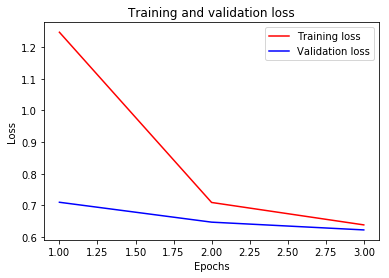

In [0]:
#with open(directory+"/history.pickle", "rb") as f:
#    history = pickle.load(f)
history_dict = history.history #current
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

fn = directory+"/history.pdf"
plt.show()
#Save
#plt.savefig(fn)
#print(f"Saved {fn}")

# Create Submission

In [0]:
submission_test_df = pd.read_csv("test.csv")
#submission_test_df
sub_data = submission_test_df["title"]
sub_lang = (submission_test_df["language"]=='spanish').astype("int32")

sub_predictions = analysis_model.predict([sub_data.array, sub_lang.array], verbose=1)
sub_predicted_categories = [inverse_cat_dict[np.argmax(p)] for p in sub_predictions]
#sub_predicted_categories[:10]
submission = pd.DataFrame({"id":range(len(sub_predicted_categories)), 
                          "category":sub_predicted_categories})
#submission
fn = directory+"/submission-"+runid+".csv"
submission[["id","category"]].to_csv(fn, index=False)
print(f"Saved {fn}")

246955/246955 [==============================] - 102s 414us/sample
Saved saved_models//meli-TFH-v3_1-191008_1642/submission-meli-TFH-v3_1-191008_1642.csv
